## PROOF OF CONCEPT ANALYSIS 

### CREATED BY: FARHAN SIDDIQUE

In [1]:
import pandas as pd
import numpy as np
import re
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial import procrustes

C:\Users\Dell\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Euclidean distance

In [2]:
file_path = 'Book1.xlsx'
data = pd.read_excel(file_path)

# Function to extract numeric values from the strings
def extract_coordinate(value):
    return float(re.search(r'[-+]?\d*\.\d+|\d+', value).group())

# Clean the X, Y, and Z columns by applying the extraction function
data['X_clean'] = data['X'].apply(extract_coordinate)
data['Y_clean'] = data['Y'].apply(extract_coordinate)
data['Z_clean'] = data['Z'].apply(extract_coordinate)

# Function to calculate 2D Euclidean distance (ignoring Z axis)
def calculate_2D_distance(row):
    return euclidean([row['X_clean'], row['Y_clean']], [0, 0])


def calculate_3D_distance(row):
    return euclidean([row['X_clean'], row['Y_clean'], row['Z_clean']], [0, 0, 0])

data['2D_distance'] = data.apply(calculate_2D_distance, axis=1)
data['3D_distance'] = data.apply(calculate_3D_distance, axis=1)


data[['X_clean', 'Y_clean', 'Z_clean', '2D_distance', '3D_distance']].head()

,X_clean,Y_clean,Z_clean,2D_distance,3D_distance
0,60.414729,8.054085,945.587125,60.949223,947.549375
1,149.391382,10.549292,946.882492,149.763388,958.652975
2,71.583399,36.679175,939.781362,80.433481,943.217130
3,129.948713,37.901992,941.575413,135.363322,951.255742
4,-57.618830,15.395844,939.260278,59.640268,941.151864


###  Bland-Altman Analysis

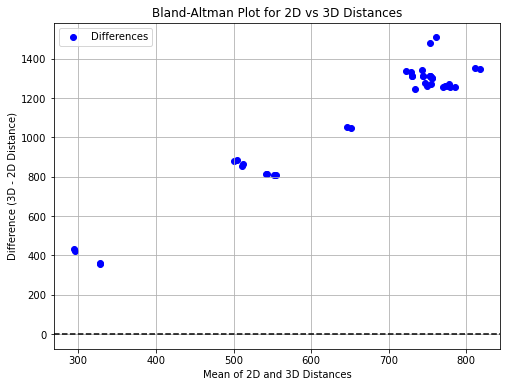

In [3]:
#: Calculate the difference and mean distances
data['difference'] = data['3D_distance'] - data['2D_distance']
data['mean_distance'] = data[['2D_distance', '3D_distance']].mean(axis=1)

plt.figure(figsize=(8, 6))
plt.scatter(data['mean_distance'], data['difference'], color='blue', label='Differences')
plt.axhline(y=0, color='black', linestyle='--')  # Line for zero difference
plt.title('Bland-Altman Plot for 2D vs 3D Distances')
plt.xlabel('Mean of 2D and 3D Distances')
plt.ylabel('Difference (3D - 2D Distance)')
plt.grid(True)
plt.legend()
plt.show()

In [4]:
data[['mean_distance', 'difference']].head()

,mean_distance,difference
0,504.249299,886.600152
1,554.208182,808.889587
2,511.825305,862.783649
3,543.309532,815.892420
4,500.396066,881.511596


### Procrustes analysis

Procrustes Distance (Disparity): 0.00000


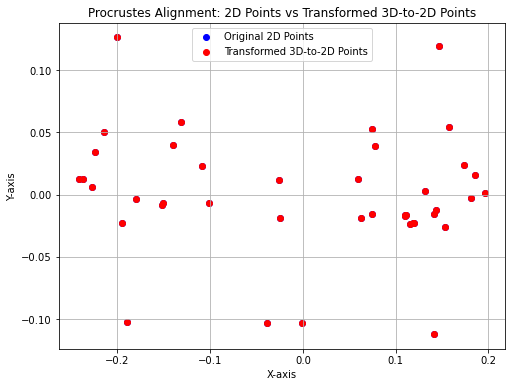

In [5]:
# Prepare the 2D and 3D (projected to 2D) point sets
data_2D = data[['X_clean', 'Y_clean']].to_numpy()  # 2D points (X, Y)
data_3D_to_2D = data[['X_clean', 'Y_clean']].to_numpy()  # Projected 3D points (X, Y from 3D)

# Perform Procrustes analysis
mtx1, mtx2, disparity = procrustes(data_2D, data_3D_to_2D)

# Procrustes distance (disparity) result
print(f'Procrustes Distance (Disparity): {disparity:.5f}')

# Plot the Procrustes alignment
plt.figure(figsize=(8, 6))
plt.scatter(mtx1[:, 0], mtx1[:, 1], color='blue', label='Original 2D Points')
plt.scatter(mtx2[:, 0], mtx2[:, 1], color='red', label='Transformed 3D-to-2D Points')
plt.title('Procrustes Alignment: 2D Points vs Transformed 3D-to-2D Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()

### Bland-Altman Plot with Confidence Intervals

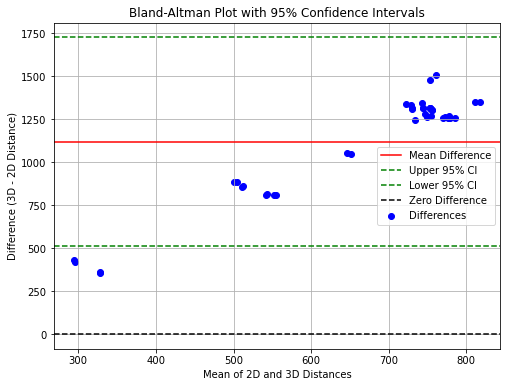

In [6]:
# Calculate mean and standard deviation of the differences
mean_diff = np.mean(data['difference'])
std_diff = np.std(data['difference'], ddof=1)

# 95% confidence intervals (mean ± 1.96 * standard deviation)
ci_upper = mean_diff + 1.96 * std_diff
ci_lower = mean_diff - 1.96 * std_diff

plt.figure(figsize=(8, 6))
plt.scatter(data['mean_distance'], data['difference'], color='blue', label='Differences')
plt.axhline(y=mean_diff, color='red', linestyle='-', label='Mean Difference')
plt.axhline(y=ci_upper, color='green', linestyle='--', label='Upper 95% CI')
plt.axhline(y=ci_lower, color='green', linestyle='--', label='Lower 95% CI')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Difference')
plt.title('Bland-Altman Plot with 95% Confidence Intervals')
plt.xlabel('Mean of 2D and 3D Distances')
plt.ylabel('Difference (3D - 2D Distance)')
plt.legend()
plt.grid(True)
plt.show()

### Visualizations for Error

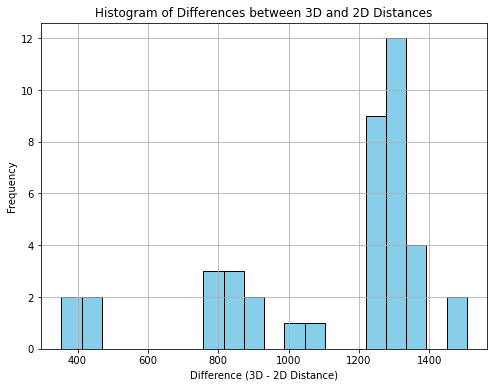

In [7]:
plt.figure(figsize=(8, 6))
plt.hist(data['difference'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Differences between 3D and 2D Distances')
plt.xlabel('Difference (3D - 2D Distance)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

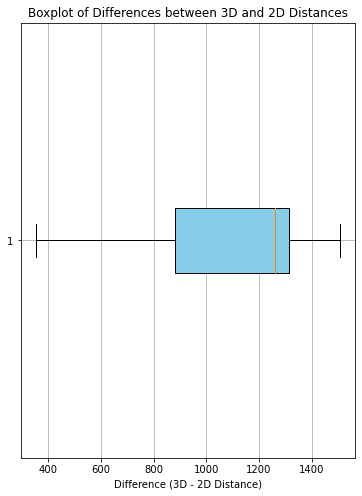

In [8]:
plt.figure(figsize=(6, 8))
plt.boxplot(data['difference'], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.title('Boxplot of Differences between 3D and 2D Distances')
plt.xlabel('Difference (3D - 2D Distance)')
plt.grid(True)
plt.show()

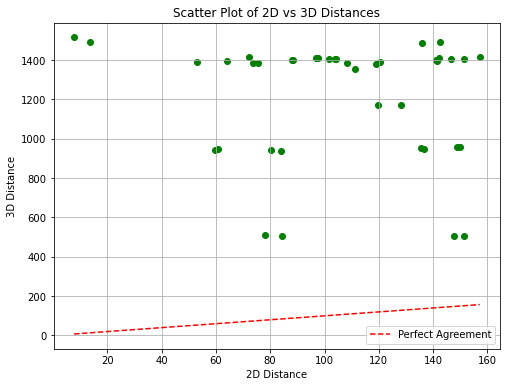

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(data['2D_distance'], data['3D_distance'], color='green')
plt.title('Scatter Plot of 2D vs 3D Distances')
plt.xlabel('2D Distance')
plt.ylabel('3D Distance')
plt.grid(True)
plt.plot([data['2D_distance'].min(), data['2D_distance'].max()],
         [data['2D_distance'].min(), data['2D_distance'].max()],
         color='red', linestyle='--', label='Perfect Agreement')
plt.legend()
plt.show()

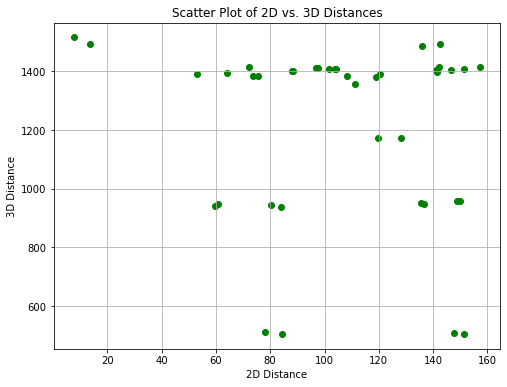

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(data['2D_distance'], data['3D_distance'], color='green', label='Data Points')
plt.title('Scatter Plot of 2D vs. 3D Distances')
plt.xlabel('2D Distance')
plt.ylabel('3D Distance')
plt.grid(True)

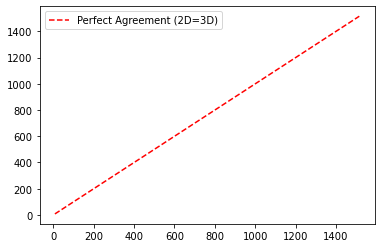

In [11]:
min_val = min(data['2D_distance'].min(), data['3D_distance'].min())
max_val = max(data['2D_distance'].max(), data['3D_distance'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Agreement (2D=3D)')

plt.legend()
plt.show()

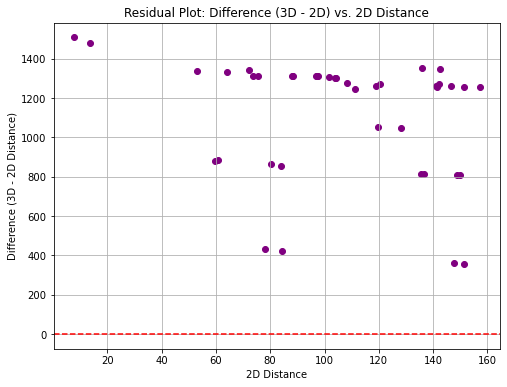

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(data['2D_distance'], data['difference'], color='purple')
plt.title('Residual Plot: Difference (3D - 2D) vs. 2D Distance')
plt.xlabel('2D Distance')
plt.ylabel('Difference (3D - 2D Distance)')
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True)
plt.show()

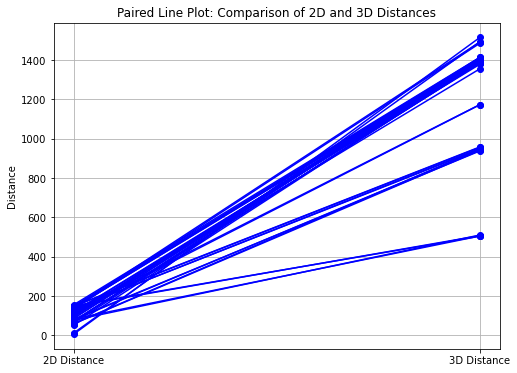

In [13]:
plt.figure(figsize=(8, 6))
for i in range(len(data)):
    plt.plot([1, 2], [data['2D_distance'][i], data['3D_distance'][i]], marker='o', color='blue')

plt.xticks([1, 2], ['2D Distance', '3D Distance'])
plt.title('Paired Line Plot: Comparison of 2D and 3D Distances')
plt.ylabel('Distance')
plt.grid(True)
plt.show()